In [1]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import *


device = K.utils.get_cuda_device_if_available()
print(device)

cpu


In [2]:
feature_count = 4096

In [3]:
%%capture
fname1 = "homography_dataset/img1.png"
fname2 = "homography_dataset/img5.png"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

feature = KF.KeyNetAffNetHardNet(feature_count, True).eval().to(device)

hw1 = torch.tensor(img1.shape[2:])
hw2 = torch.tensor(img1.shape[2:])

adalam_config = {"device": device}

with torch.inference_mode():
    lafs1, resps1, descs1 = feature(K.color.rgb_to_grayscale(img1))
    lafs2, resps2, descs2 = feature(K.color.rgb_to_grayscale(img2))
    dists, idxs = KF.match_adalam(
        descs1.squeeze(0),
        descs2.squeeze(0),
        lafs1,
        lafs2,  # Adalam takes into account also geometric information
        config=adalam_config,
        hw1=hw1,
        hw2=hw2,  # Adalam also benefits from knowing image size
    )

In [4]:
print(f"{idxs.shape[0]} tentative matches with AdaLAM")

1379 tentative matches with AdaLAM


In [5]:
def get_matching_keypoints(lafs1, lafs2, idxs):
    mkpts1 = KF.get_laf_center(lafs1).squeeze()[idxs[:, 0]].detach().cpu().numpy()
    mkpts2 = KF.get_laf_center(lafs2).squeeze()[idxs[:, 1]].detach().cpu().numpy()
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(lafs1, lafs2, idxs)

Fm, inliers = cv2.findHomography(mkpts1, mkpts2, cv2.USAC_ACCURATE)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with AdaLAM")

775 inliers with AdaLAM


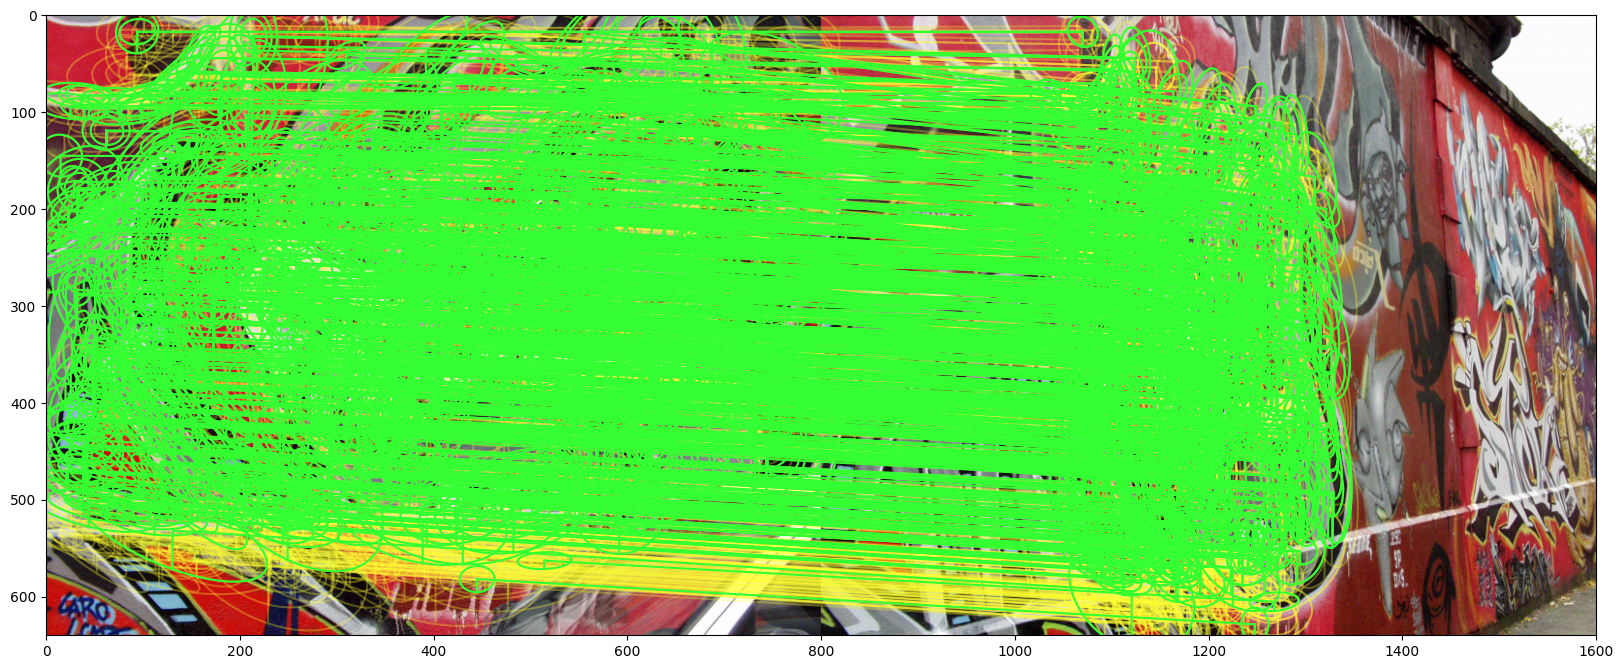

In [6]:
draw_LAF_matches(
    lafs1,
    lafs2,
    idxs,
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)